In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow.keras.backend as kb

print(tf.__version__)

tf.config.list_physical_devices()

2.9.1


In [76]:
kb.clear_session()

# Loading the training and test data

The training and testing data sets are generated by uniformly sampling on the latin hypercube spanned by parameters $\Omega_m$,  $\Omega_b$, $h$, $n_s$ and $\sigma_8$ in the following ranges:

| Data set | $\Omega_m$ | $\Omega_b$   | $h$       | $n_s$     | $\sigma_8$ | $N$ |
|----------|-----------|-------------|-----------|-----------|------------|-------|
| Training | [0.1,0.5] | [0.03,0.07] | [0.5,0.9] | [0.8,1.2] | [0.6,1.0]  | 2000 |
| Testing  | [0.2,0.4] | [0.03,0.06] | [0.6,0.8] | [0.9,1.1] | [0.7,1.0]  | 200 |

Overall, we have 2000 training and 200 test samples.

Using these parameters we generate linear power spectra $P(k)$ and by convolving with the survey window function we obtain observed power spectrum $P_\mathrm{obs}(k)$.

Here we build a neural network that takes as an input $P(k)$ (features) and outputs the ratio $R(k)=P_\mathrm{obs}(k)\,/\,P(k)$ (labels). This way the network will only emphasize on learning the change of shape due to convolution and not the amplitude. Therefore, $P_\mathrm{obs}(k)= R(k)\,P(k)$.

In [41]:
print('Loading data!')
N_TRAIN = 2000
N_TEST = 200

features = np.array([np.loadtxt('../data/latin_hypercube/'+str(i)+'/Pk_mm_z=0.000_convfft_r700.txt')[:,1]\
                 for i in range(0,N_TRAIN)])
labels = np.array([np.loadtxt('../data/latin_hypercube/'+str(i)+'/Pk_mm_z=0.000_convfft_r700.txt')[:,2]\
                   for i in range(0,N_TRAIN)]) / features

k = np.loadtxt('../data/latin_hypercube/0/Pk_mm_z=0.000_convfft_r700.txt')[:,0]

labels = np.array(labels)[:,:np.min(np.where(k>0.2))]



test_features = np.array([np.loadtxt('../data/latin_cube_test/'+str(i)+'/Pk_mm_z=0.000_convfft_r700.txt')[:,1]\
                 for i in range(0,N_TEST)])

test_labels = np.array([np.loadtxt('../data/latin_cube_test/'+str(i)+'/Pk_mm_z=0.000_convfft_r700.txt')[:,2]\
                 for i in range(0,N_TEST)]) / test_features

test_labels = np.array(test_labels)[:,:np.min(np.where(k>0.2))]


N_FEATURES = features.shape[1]
N_LABELS = labels.shape[1]

print('Number of training samples: ' + str(N_TRAIN) + ', number of features [length of P(k)]: ' \
      + str(N_FEATURES) + ', number of labels [length of R(k)]: ' + str(N_LABELS))

print('Number of test samples: ' + str(N_TEST))




Loading data!
Number of training samples: 2000, number of features [length of P(k)]: 127, number of labels [length of R(k)]: 47
Number of test samples: 200


Plotting 2 samples of feature and labels

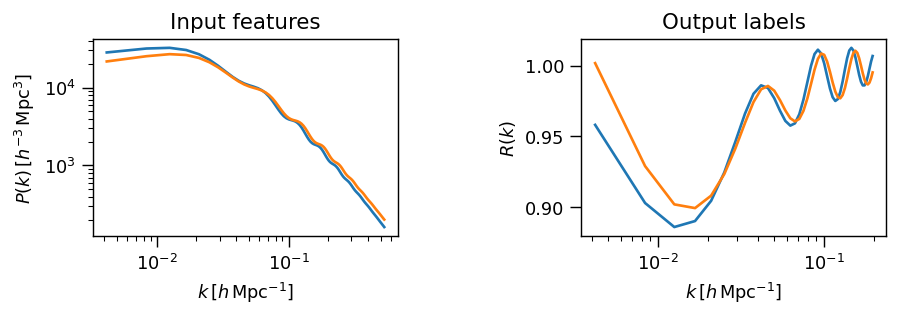

In [71]:
plt.rcParams['figure.dpi'] = 120
plt.rcParams.update({'font.size': 10})
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.minor.size'] = 3

plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3



plt.figure(figsize=(8,2), dpi=128)
plt.subplots_adjust(hspace=0.25, wspace=0.6)

plt.subplot(1,2,1)
plt.title('Input features')
plt.loglog(k, test_features[0], k, test_features[20])
plt.ylabel(r'$P(k)\,[h^{-3}\,\mathrm{Mpc}^3]$')
plt.xlabel(r'$k\,[h\,\mathrm{Mpc^{-1}}]$')

plt.subplot(1,2,2)
plt.title('Output labels')

plt.semilogx(k[:test_labels.shape[1]], test_labels[0], k[:test_labels.shape[1]], test_labels[20])
plt.ylabel(r'$R(k)$')
plt.xlabel(r'$k\,[h\,\mathrm{Mpc^{-1}}]$')

plt.show()





# Building the neural network

The neural network models used has 1D convolution layer and a dropout layer for regularization. The final layer is the fully connected one that has the number of neurons equal to number of labels. This netwrok also includes the pre-processing custom layer (NormMax) that normalizes the input on its maximum value. This reduces a dynamic range of the input function and makes the training faster.

In [15]:
class Conv1DTranspose(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, kernel_initializer='glorot_uniform',\
                 strides=1, padding='same',\
                 ):
        super().__init__()
        self.conv2dtranspose = tf.keras.layers.Conv2DTranspose(
          filters, (kernel_size, 1), (strides, 1), padding, kernel_initializer=kernel_initializer,
            use_bias=False
        )

    def call(self, x):
        x = tf.expand_dims(x, axis=2)
        x = self.conv2dtranspose(x)
        x = tf.squeeze(x, axis=2)
        return x


# Custom layer that normalizes the input on its maximum value
class NormMax(layers.Layer):

    def __init__(self, **kwargs):
        super(NormMax, self).__init__(**kwargs)

    def build(self, input_shape):
        super(NormMax, self).build(input_shape)
        
    def call(self, inputs):
        return kb.transpose(kb.transpose(inputs)/kb.max(inputs, axis=1))


    

def build_model(N_FEATURES, N_LABELS, lr_schedule):
    model = keras.Sequential([
    NormMax(input_shape=(N_FEATURES,)),
    layers.Lambda(lambda x: kb.expand_dims(x, axis=2)),
    layers.Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=[N_FEATURES,1],\
                  padding='same', use_bias=True \
                  ),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(N_LABELS, activation='softplus')
    ])

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
    optimizer = tf.keras.optimizers.Adam(lr_schedule)

    model.compile(loss='mean_absolute_percentage_error',
                optimizer=optimizer,
                metrics=['accuracy'])
    return model
                    



Througout the training we adjust the learning rate by lowering it after each epoch.

In [18]:
!pip install -q git+https://github.com/tensorflow/docs

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


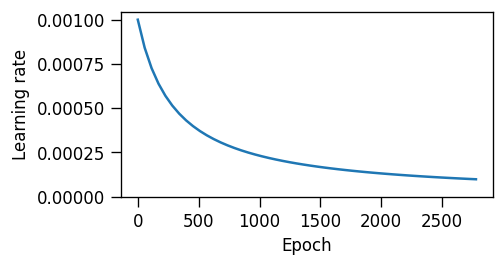

In [72]:
EPOCHS = 1000
N_TRAIN = features.shape[0]
BATCH_SIZE = 55
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

    
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*300,
    decay_rate=1,
    staircase=False)


step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (4,2))
plt.plot(step/STEPS_PER_EPOCH, lr.numpy())
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.show()

Here we fit the model with early stop feature enabled, which monitors the loss function and stops it, if it is not lowered after 100 epochs

In [21]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=100)


model = build_model(N_FEATURES, N_LABELS, lr_schedule)
model.summary()

history = model.fit(
  features, labels,
  epochs=EPOCHS, validation_split = 0.05, verbose = 0, batch_size = BATCH_SIZE, 
    steps_per_epoch = STEPS_PER_EPOCH,
  callbacks=[tfdocs.modeling.EpochDots(), early_stop])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 norm_max_6 (NormMax)        (None, 127)               0         
                                                                 
 lambda_6 (Lambda)           (None, 127, 1)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 127, 16)           64        
                                                                 
 dropout_5 (Dropout)         (None, 127, 16)           0         
                                                                 
 flatten_5 (Flatten)         (None, 2032)              0         
                                                                 
 dense_4 (Dense)             (None, 47)                95551     
                                                                 
Total params: 95,615
Trainable params: 95,615
Non-trai

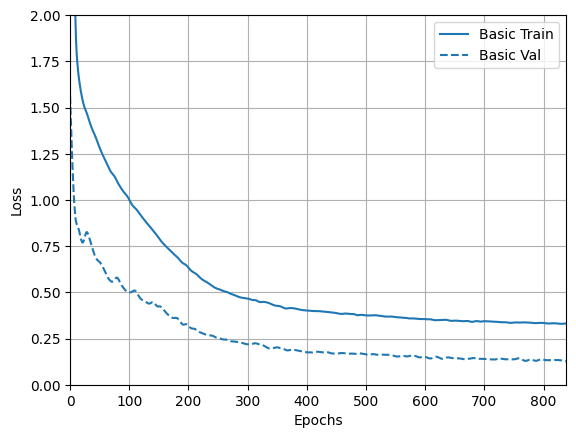

In [26]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Basic': history}, metric = "loss")
plt.ylim([0, 2])
plt.ylabel('Loss')
plt.show()



In [43]:
model.save('saved_model/conv_model_v1_w_normed_output')

In [27]:
model.load_weights('saved_model/conv_model_v1_w_normed_output')

# Analyzing the perfomance of the model

Here we compute a mean absolute error per test sample to check how accurate is the model, which is defined as
\begin{equation}
\label{eq:loss}
    {\rm MAE} = \frac{1}{N}\sum_{i=1}^N |y^\mathrm{pred}_i/y^\mathrm{truth}_i-1|\,.
\end{equation}
Here $y^\mathrm{pred}_i$ is the prediction of the neural network learning model, the $y^\mathrm{truth}_i$ is the truth from training data set and $N$ is the number of entries in these data vectors. This is also our loss function that the network tried to minimize.

 Turns out this error is below percent for each test sample, which inicates that model works well.

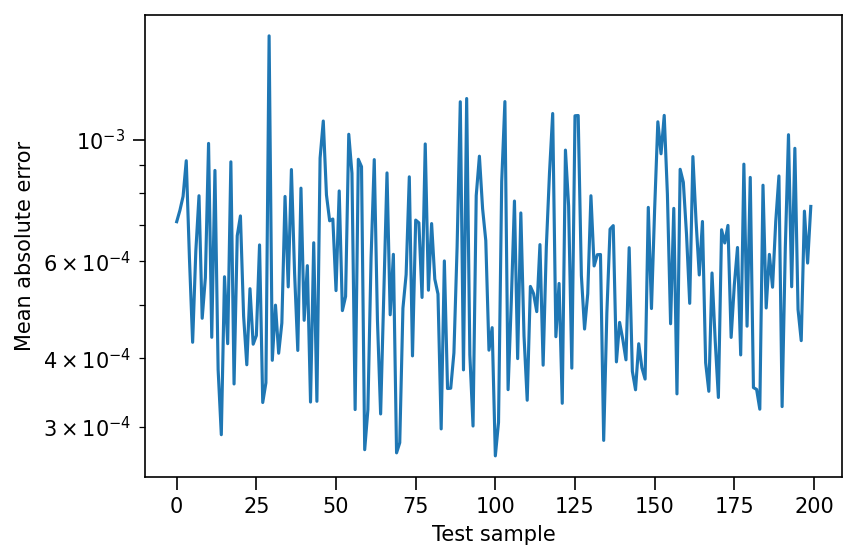

In [75]:
test_predictions = np.array([model.predict(test_features[i:i+1], verbose=0)[0] for i in range(N_TEST)])

abs_error = np.abs(test_predictions / test_labels -1)


mean_accuracy_per_sample = np.mean(abs_error, axis=1)


plt.figure(figsize=(6,4), dpi=150)

plt.semilogy(mean_accuracy_per_sample)
plt.xlabel('Test sample')
plt.ylabel('MAE')

plt.show()




1/1 [==============================] - 0s 13ms/step


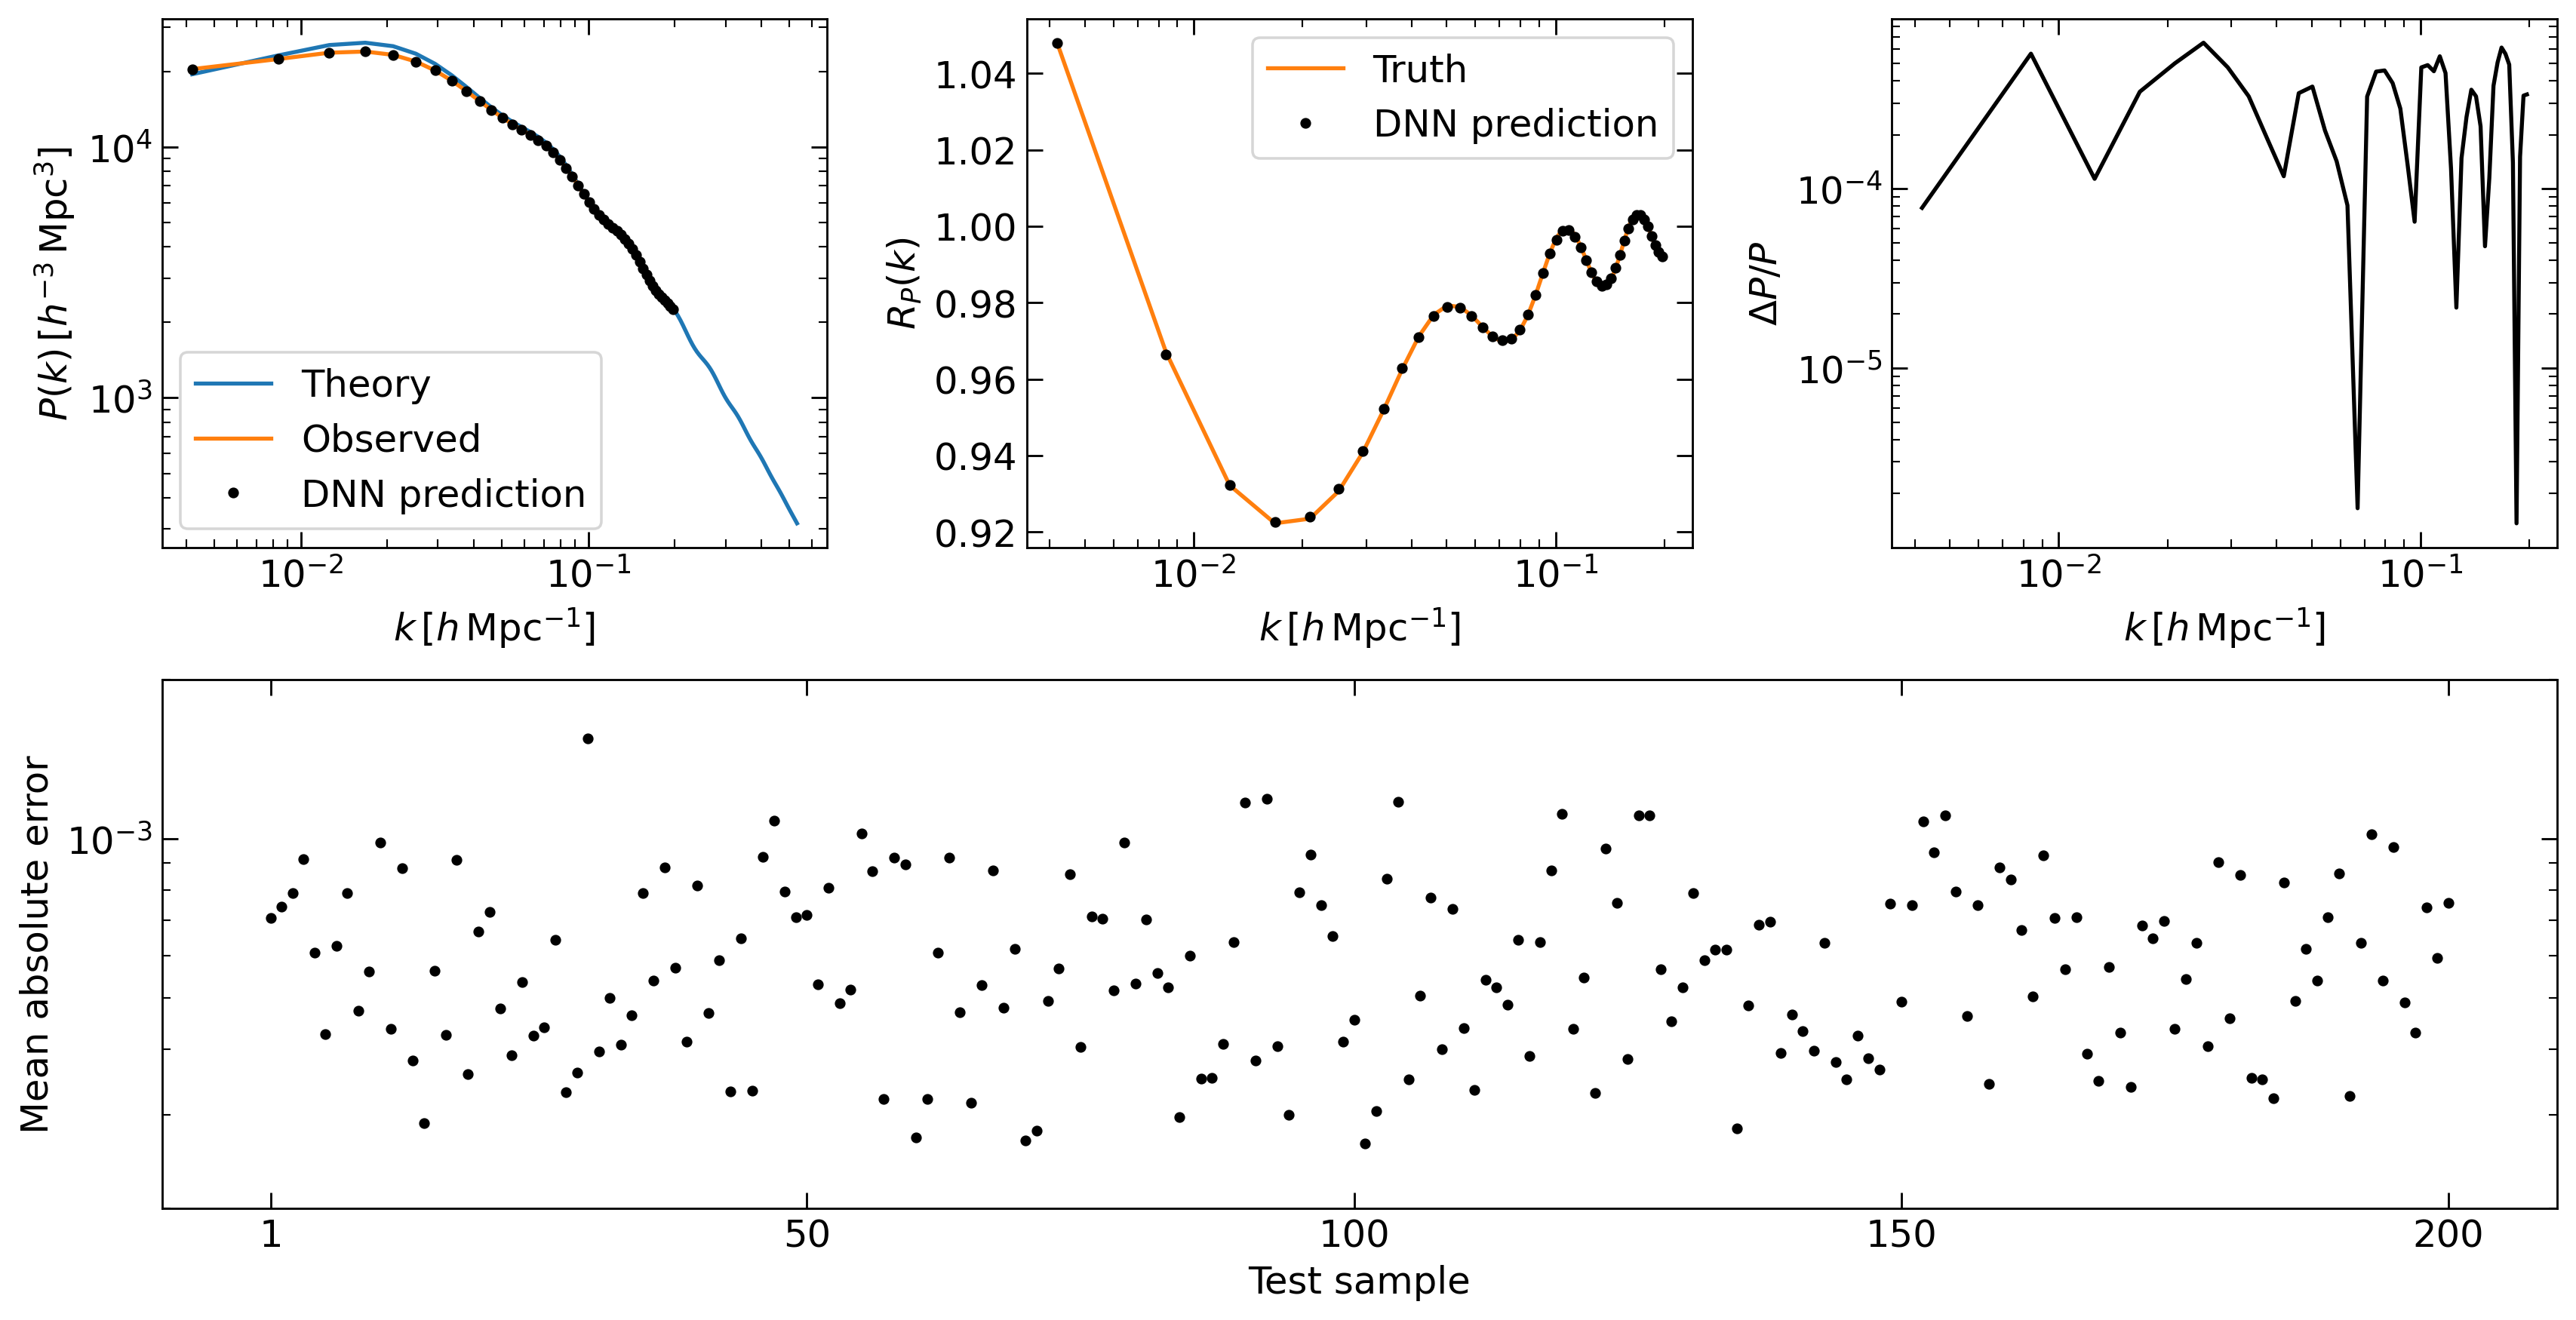

In [55]:

TEST_SAMPLE = 93

bisp_data = np.loadtxt('bisp_test_sample_138_plotting_data.txt')
bisp_mae = np.loadtxt('bisp_model_mae.txt')

prediction = model.predict(test_features[TEST_SAMPLE:TEST_SAMPLE+1])[0]


plt.figure(figsize=(8*2,4*2), dpi=256)

plt.subplots_adjust(hspace=0.25, wspace=0.3)



plt.subplot(2,3,1)
plt.tick_params(axis="both",direction="in", top=True, right=True, which='both')


plt.loglog(k[:N_FEATURES], test_features[TEST_SAMPLE], label='Theory')

plt.loglog(k[:N_LABELS], test_labels[TEST_SAMPLE] * test_features[TEST_SAMPLE,:N_LABELS], label='Observed')

plt.loglog(k[:N_LABELS], prediction * test_features[TEST_SAMPLE,:N_LABELS], \
           label='DNN prediction', marker='.', linestyle='', color='k')



plt.ylabel(r'$P(k)\,[h^{-3}\,\mathrm{Mpc}^3]$')
plt.xlabel(r'$k\,[h\,\mathrm{Mpc^{-1}}]$')


plt.legend()



plt.subplot(2,3,2)
plt.tick_params(axis="both",direction="in", top=True, right=True, which='both')


plt.semilogx(k[:N_LABELS], test_labels[TEST_SAMPLE], \
             label='Truth', color='C1')

plt.semilogx(k[:N_LABELS], prediction, label='DNN prediction', marker='.', linestyle='', color='k')


plt.ylabel(r'$R_P(k)$')
plt.xlabel(r'$k\,[h\,\mathrm{Mpc^{-1}}]$')


plt.legend()



plt.subplot(2,3,3)
plt.tick_params(axis="both",direction="in", top=True, right=True, which='both')

plt.loglog(k[:N_LABELS], np.abs(prediction
                                       /test_labels[TEST_SAMPLE]-1), color='k')




plt.ylabel(r'$\Delta P / P$')
plt.xlabel(r'$k\,[h\,\mathrm{Mpc^{-1}}]$')


plt.subplot(2,1,2)
plt.tick_params(axis="both",direction="in", top=True, right=True, which='both')

plt.semilogy(np.arange(1,N_TEST+1), mean_accuracy_per_sample, marker='.', linestyle='', color='k')
plt.xlabel('Test sample')
plt.ylabel('Mean absolute error')
plt.gca().xaxis.set_ticks([1,50,100,150,200])

plt.ylim([2e-4,2e-3])


plt.savefig('plots/ps_example_fft.png', bbox_inches='tight', dpi=256)
plt.savefig('plots/ps_example_fft.pdf', bbox_inches='tight')

plt.show()

